# Predicting Diabetes Diagnosis Using Health Factors
Authors: Abby Howard, Arai Lubas, Ella Stasko


# Introduction
We are interested in exploring what combination of the collected features best predicts whether an individual has diabetes. Given these inputs, we want to determine whether we can create a model to predict this accurately.

Our team will use the Healthcare Diabetes Dataset from Kaggle. Each instance represents various aspects of an individual’s health data and their diagnosis or non-diagnosis of diabetes. It was last updated in 2023, meaning the data is recent and relevant. The dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK). There are 2768 patients included in the data, with 10 features recorded. Each instance represents a unique individual with recorded features listed below:

1.	**Id**: Unique identifier for each data entry.
2. **Pregnancies**: Number of times pregnant. (Includes people who cannot get pregnant).
4.	**Glucose**: Plasma glucose concentration over 2 hours in an oral glucose tolerance test.
5.	**BloodPressure**: Diastolic blood pressure (mm Hg).
6.	**SkinThickness**: Triceps skinfold thickness (mm). Indicator of body fat distribution.
7.	**Insulin**: 2-Hour serum insulin (mu U/ml).
8.	**BMI**: Body mass index (weight in kg / height in m^2).
9.	**DiabetesPedigreeFunction**: Diabetes pedigree function, a genetic score of diabetes.
10.	**Age**: Age in years.
11.	**Outcome**: Binary classification indicating the presence (1) or absence (0) of diabetes.
   
Features we are particularly interested in to predict whether the individual has diabetes are glucose, diabetes pedigree function, and insulin features. We are surprised by the skin thickness and intrigued to determine whether this has any predictive value. 

# Exploratory Data Analysis

In [128]:
# Import needed modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings 
from scipy.stats import ttest_ind
from sklearn import tree, ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore', category=FutureWarning)

# Summary Statistics

First we need to read in our data, and confirm there are no missing values. 

In [7]:
# Read in the dataset and set the patient ID as the index
data = pd.read_csv('Healthcare-Diabetes.csv', index_col= 'Id')
data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,,,
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,0,0,25.6,0.201,30,0
7,3,78,50,32,88,31.0,0.248,26,1
8,10,115,0,0,0,35.3,0.134,29,0
9,2,197,70,45,543,30.5,0.158,53,1


In [9]:
# Check for missing values 
data.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

We noticed that there are multiple columns with an abundant amount of zeros for features that cannot equal zero (age, BMI, Insulin etc.) This implies that instead of NA values in the dataset, the authors set missing values to 0. To understand how vast the missing values are for each column, we will quantify how many zeroes are in each column. 

In [12]:
# Determine zero counts for each column where a value of zero is not feasible
(data.iloc[: ,1:8] == 0).sum()

Glucose                       18
BloodPressure                125
SkinThickness                800
Insulin                     1330
BMI                           39
DiabetesPedigreeFunction       0
Age                            0
dtype: int64

We assume that for features: Glucose, Blood Pressure, Skin Thickness, Insulin, BMI, Diabetes Pedigree Function, and Age values of zero are improbable and thus are missing values that need to be removed. 

However, Before dropping any columns, we evaluated each feature individually.

In [15]:
# For data analysis, create DataFrames for each variable against outcome,
# removing zero values to assess trends via violin plots
        
dataframes = {} 

# Generating individual dataframes for each variable containing the variable and outcome
for col in data:
    if col == 'Pregnancies':
        dataframes[col] = data.loc[:, (col, 'Outcome')]
    if col == 'Outcome':
        pass
    # Remove zero value rows for all variables except pregancies and outcome
    else:
        dataframes[col] = data.loc[:, (col, 'Outcome')].query('`{}` != 0'.format(col))

# Create a variable to hold the desired palette colors for graphs
colors = ['skyblue','indianred']

Using each variables individual cleaned dataframes we can visualize their distributions to try to observe any differences within a variable between the two different outcomes.

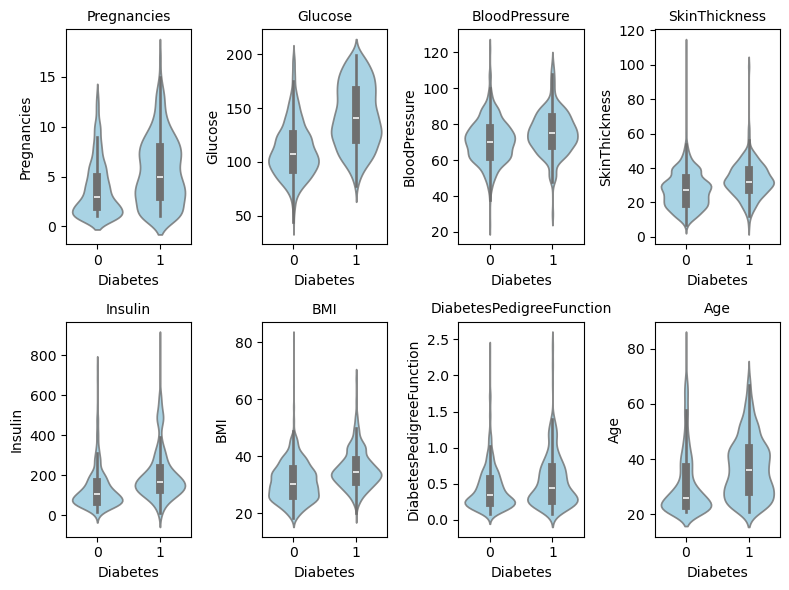

In [18]:
plt.figure(3, figsize = (8,6), clear = True)

subplot_num = 1

for key in dataframes:
    plt.subplot(2, 4, subplot_num)
    plt.title(f"{key}", size = 10)
    sns.violinplot(data = dataframes[key], 
                   y = key, 
                   x = 'Outcome', 
                   alpha = 0.8,
                   palette = ['skyblue', 'skyblue']
                  )
    plt.xlabel('Diabetes')
    plt.xticks([0,1])
    subplot_num +=1 

plt.tight_layout()

**Pregnancies**: It appears that patients with diabetes have a wider distribution of number of pregnancies. This becomes hard to interpret as the data includes patients unable to have children and doesn't discriminate by sex making this variable not a likely feature for predicting our outcome without extended analysis on the data.

**Glucose**: Patients with diabetes have on average a higher blood glucose level than those without this is a possible feature for prediction as the distributions appear distinct from one another.

**Blood Pressure**: Patients with diabetes have a slighly higher average diastolic blood pressure than those without, but overall the distributions appear similar.

**Skin Thickeness**: Patients with diabetes have a slighly higher average skin thickness than those without, but overall the distributions appear similar.

**Insulin**: Patients with diabetes have a higher average 2-hour serum insulin than those without.

**BMI**: Patients with diabetes have a higher average BMI.

**Diabetes Pedigree Function**: These have very similar distributions.

**Age**: Patients with diabetes are, on average, older than those without.

To further examine the relationships between the variables and diabetes diagnoses, we performed two-sample independent t-tests to evaluate the differences in means between the groups and whether or not it they are statistically significant. 

In [22]:
# Store the numerical feature names to test
features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction','Age']

# Store t-test results
t_test_results = []

# Loop through each feature to perform the t-tests
for feature in features:
    group_negative = dataframes[feature][dataframes[feature]['Outcome'] == 0][feature]
    group_positive = dataframes[feature][dataframes[feature]['Outcome'] == 1][feature]
    mean_diff = np.abs(group_negative.mean()-group_positive.mean())

    # Perform t-test
    t_stat, p_val = ttest_ind(group_negative, group_positive, axis = 0, equal_var = False)

    # Store results
    t_test_results.append({
        'Feature': feature,
        'Absolute Mean Difference': mean_diff,
        'T-Statistics': round(t_stat, 3),
        'P-value': p_val,
        'Significant': p_val < 0.05
    })
t_test_df = pd.DataFrame(t_test_results)
t_test_df

,Feature,Absolute Mean Difference,T-Statistics,P-value,Significant
0,Pregnancies,1.804954,-12.825,1.095364e-35,True
1,Glucose,31.649077,-28.175,2.541167e-143,True
2,BloodPressure,4.577578,-9.215,8.382725e-20,True
3,SkinThickness,5.688812,-11.485,3.765410e-29,True
4,Insulin,71.373846,-10.886,8.967390e-26,True
5,BMI,4.379776,-16.035,1.749866e-54,True
6,DiabetesPedigreeFunction,0.110130,-8.015,2.088811e-15,True
7,Age,5.876161,-13.109,9.236400e-38,True


All features have a significant P-Value. While only the means of Glucose and Insulin are drastically different, because the sample sizes are all large it creates large test statistics and small p-values. P-Values are often ignored in clinical work because it is more clinically relevant to look at the magnitude of the difference of the relevant metric. With a large enough sample size even small changes that are not clinically relevant could be statistially significant. As seen above the mean difference of Blood Pressure between patients with and without diabetes is ~4.6, while this is statistically significant, a difference in Blood Pressure of 4.6mmHg is not clinically relevant. 

Next we cleaned the entire data set. Due to the high number of missing insulin values we have chosen to drop that column from our analysis. We will also drop skin thickness as there are a lot of missing values as well and doesn't necissarily look like a great predictor based on the distributions

In [26]:
# Remove features from working dataset with substantial missing values: Insulin, Skin Thickness, BMI
cleaned_data = data.query('Glucose !=0 & BloodPressure !=0 & BMI !=0').copy()
cleaned_data.drop(['Insulin','SkinThickness'], axis = 1, inplace = True)
cleaned_data

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,
1,6,148,72,33.6,0.627,50,1
2,1,85,66,26.6,0.351,31,0
3,8,183,64,23.3,0.672,32,1
4,1,89,66,28.1,0.167,21,0
5,0,137,40,43.1,2.288,33,1
...,...,...,...,...,...,...,...
2764,2,75,64,29.7,0.370,33,0
2765,8,179,72,32.7,0.719,36,1
2766,6,85,78,31.2,0.382,42,0


Now we will take a look at the number of participants in the dataset.

In [29]:
# Count the number of participants in the cleaned sample
cleaned_data.shape

(2612, 7)

With 2612 participants left in the cleaned data, and 7 columns of health features, lets visualize some key aspects of our data set. 

/var/folders/8r/f56gfkgx46n2_nt25p4yj3_c0000gn/T/ipykernel_93534/1115479598.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


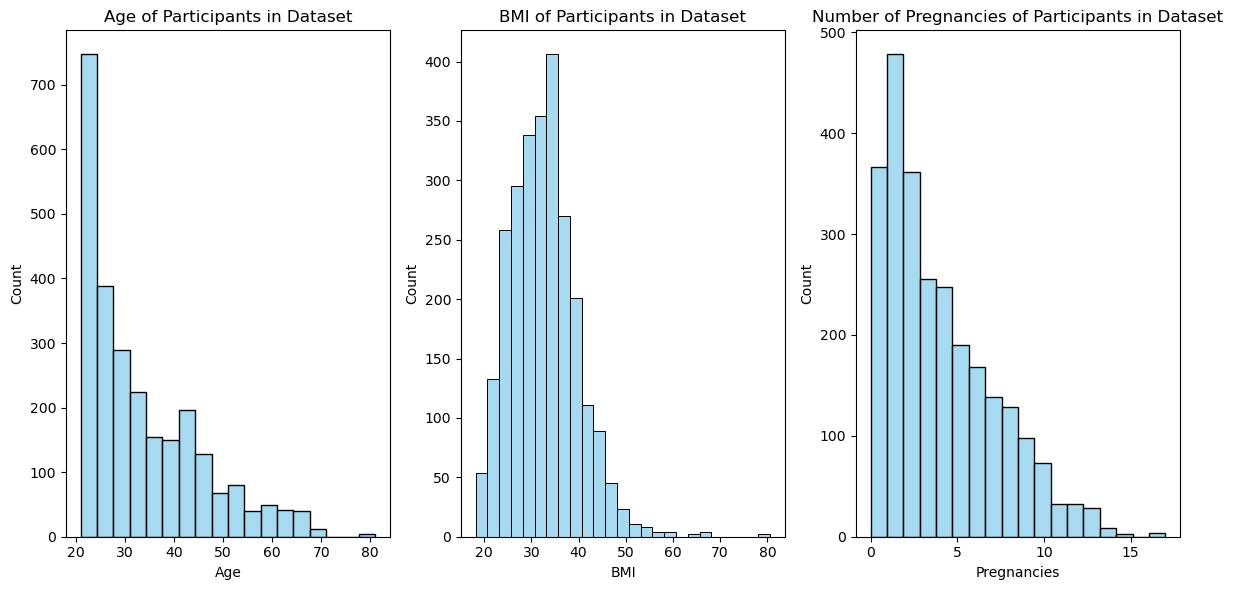

In [32]:
# Plot the Age Distribution of participants in a subplot
plt.figure(1, figsize = (12,6), clear = True)
plt.tight_layout()
plt.subplot(1,3,1)
sns.histplot(cleaned_data, 
             x = 'Age',
             bins = 18,
             color = 'skyblue')
plt.title('Age of Participants in Dataset')

# Plot the BMI distribution of Participants in a sub plot
plt.subplot(1,3,2)
sns.histplot(cleaned_data, 
             x = 'BMI',
             bins = 25,
             color = 'skyblue')
plt.title('BMI of Participants in Dataset')

# Plot the Distribution of the number of pregnancies in a subplot
plt.subplot(1,3,3)
sns.histplot(cleaned_data, 
              x = 'Pregnancies',
              bins = 18,
              color = 'skyblue')
plt.title('Number of Pregnancies of Participants in Dataset')

plt.tight_layout();

Participants in the data set have a normal distribution of BMI with minimal outliers, and a right skew of both age and number of pregnancies. It is important to note that the pregancies column includes men and those who cannot become pregnant, resulting in a very high number of zero pregnancies. 

This is relevant because diabetes is known to be correlated with pregnancy, but without the differentiation in sex of a patient, it wll be difficult to determine which individuals are women/those with a uterus who have not been pregnant, or a man/those who do not have a uterus. This may eliminate the potential to examine the impact of pregnancy on diabetes diagnosis.


Below, we plot the number of participants with diabetes against Glucose levels

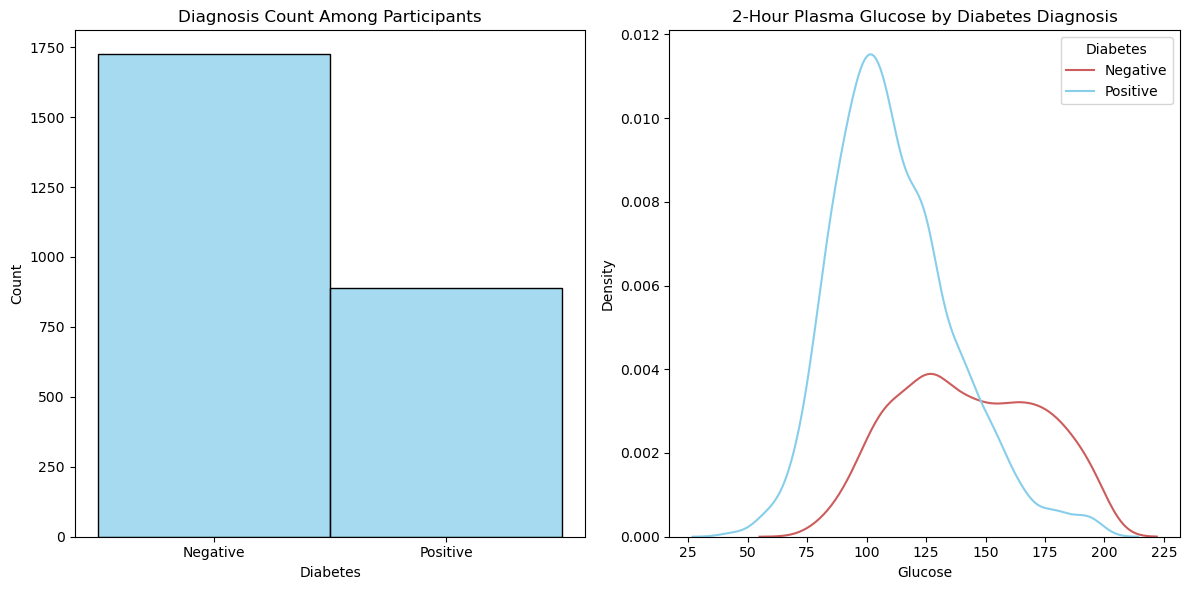

In [36]:
# Plot the number of participants with diabetes
plt.figure(2, figsize = (12,6), clear = True)
plt.subplot(1,2,1)
sns.histplot(cleaned_data, 
              x = 'Outcome',
              bins = 2,
              color = 'skyblue')
plt.title('Diagnosis Count Among Participants')
plt.xlabel('Diabetes')
plt.xticks([0.25, .75], ['Negative','Positive'])

# Plot glucose levels separated and color coded by Diabestes Diagnosis
plt.subplot(1,2,2)
sns.kdeplot(cleaned_data,
             x = 'Glucose',
             hue = 'Outcome',
             palette = colors)
plt.legend(title = 'Diabetes',
           labels = ['Negative','Positive'])
plt.title('2-Hour Plasma Glucose by Diabetes Diagnosis')
plt.tight_layout()

Here we see that there are about half as many participants with diabetes in the study sample. In addition, the glucose distributions for patients with diabetes and without diabetes both appear to be rather normal in their distribution. However, the diabetes distribution is shifted to the right with a higher average and seems to be flatter and wider than the non-diabetes distribution.

Now lets examine two variables at a time, differentiated by outcome by color. We chose to examine BMI & Glucose, Blood Pressure & Glucose, and Diabetes Pedigree Function & Glucose. We chose these variables to compare with a patients Glucose concentration as we thought these would be the factors most related to glucose concentration, and thereforegood predictors of Diabetes diagnosis. 

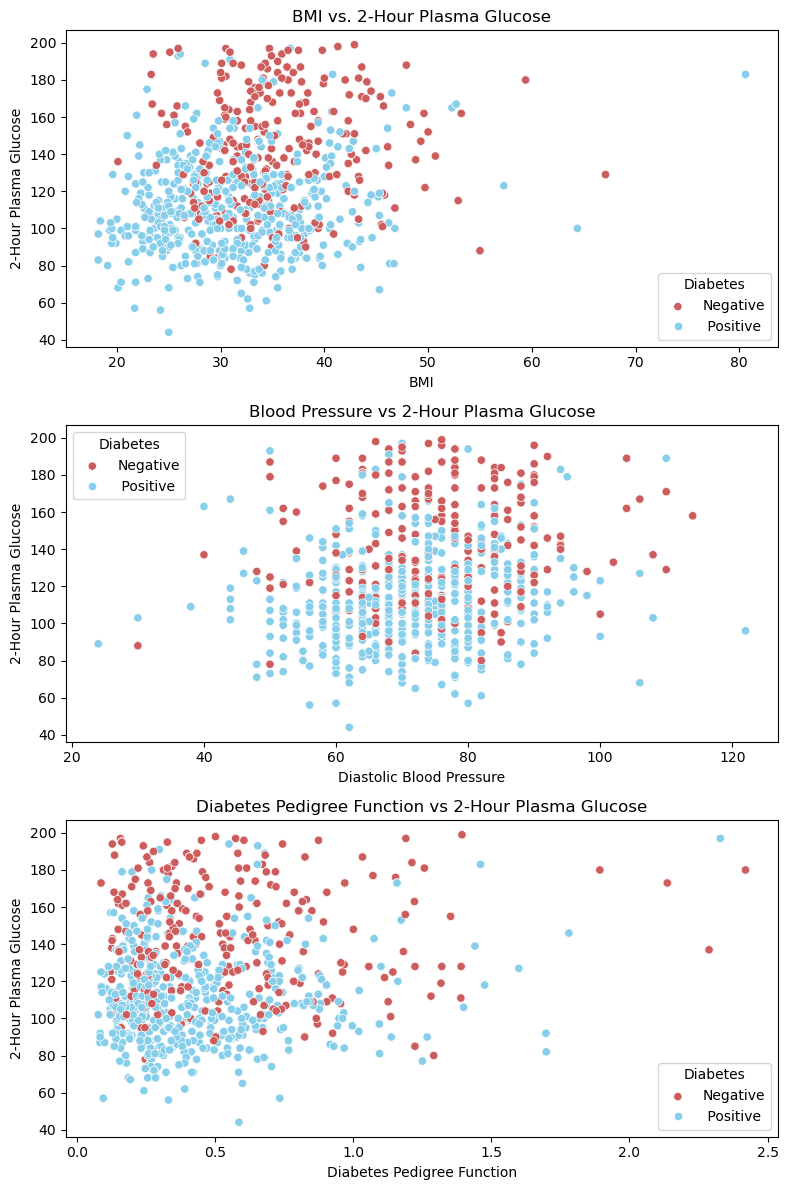

In [39]:
# Graph various variables vs. glucose
plt.figure(4, figsize = (8,12), clear = True)
plt.subplot(3,1, 1)

# Create plot one of the subplot
sns.scatterplot(x = 'BMI',
           y = 'Glucose',
           data = cleaned_data,
           hue = 'Outcome',
           palette = colors
               )
plt.legend(title = 'Diabetes',
            labels = ['Negative', ' Positive'] )

# Edit the titles of the first subplot
plt.title('BMI vs. 2-Hour Plasma Glucose')
plt.xlabel('BMI')
plt.ylabel('2-Hour Plasma Glucose')

# Create plot two of the subplot
plt.subplot(3,1, 2)
sns.scatterplot(x = 'BloodPressure',
           y = 'Glucose',
           data = cleaned_data,
           hue = 'Outcome',
           palette = colors,
            )
plt.legend(title = 'Diabetes',
            labels = ['Negative', ' Positive'] )
# Edit the titles of the second subplot
plt.title('Blood Pressure vs 2-Hour Plasma Glucose')
plt.xlabel('Diastolic Blood Pressure')
plt.ylabel('2-Hour Plasma Glucose')

# Create plot three of the subplot
plt.subplot(3,1, 3)
sns.scatterplot(x = 'DiabetesPedigreeFunction',
           y = 'Glucose',
           data = cleaned_data,
           hue = 'Outcome',
           palette = colors
               )
plt.legend(title = 'Diabetes',
            labels = ['Negative', ' Positive'] )

# Edit the titles of the third subplot
plt.title('Diabetes Pedigree Function vs 2-Hour Plasma Glucose')
plt.xlabel('Diabetes Pedigree Function')
plt.ylabel('2-Hour Plasma Glucose')
plt.tight_layout()


Using these plots we can see potential relationships with Diabetes Pedigree Function, Blood Pressure, and BMI with Glucose concentrations. Next, we will examine the relationships and models of the data more closely to confirm if these are valuable features to predict Diabetes diagnosis in patients. 


# Pregnancies Sub-Analysis

Due to the indisciminate nature of the pregnancies data category, we will do a sub analysis of all pregnancies to examine its relationship with diabetes. 

In [44]:
# Create a new dataset of only rows of pregnancies
pregnancies = cleaned_data[cleaned_data['Pregnancies']>0]
# Count the number of rows in this data set
pregnancies.shape

(2246, 7)

There are 2246 instances of at least one pregnancy in the data. Next we will  examine the relationship between pregnancies and diabetes diagnosis. 

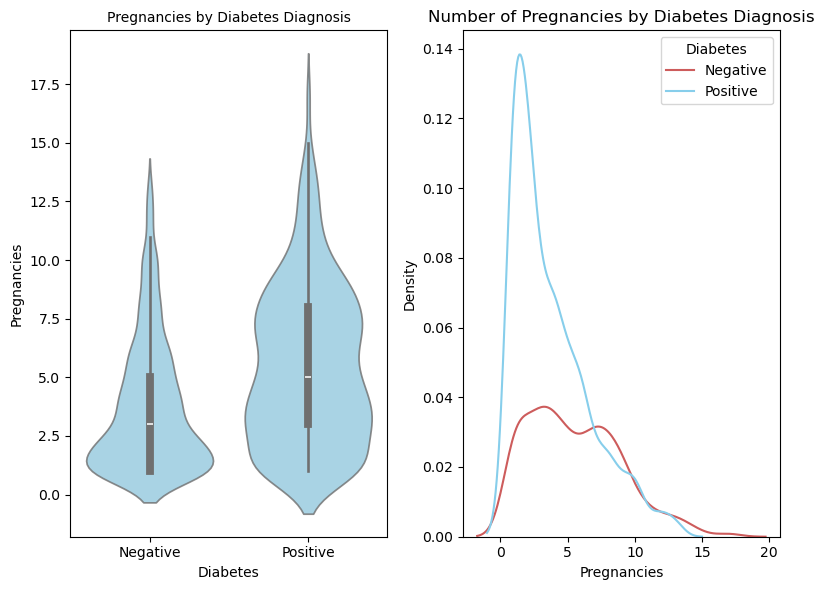

In [47]:
# Plot the number of pregnancies separated and color coded by Diabetes Diagnosis
plt.figure(5, figsize = (8,6), clear = True)
plt.subplot(1, 2, 1)
plt.title('Pregnancies by Diabetes Diagnosis', size = 10)
sns.violinplot(data = pregnancies, 
                   y = 'Pregnancies', 
                   x = 'Outcome', 
                   alpha = 0.8,
                   palette = ['skyblue', 'skyblue']
                  )
plt.xlabel('Diabetes')
plt.xticks([0,1],['Negative','Positive'])
    
# Plot pregnancies on a kde plot
plt.subplot(1,2,2)
sns.kdeplot(pregnancies,
             x = 'Pregnancies',
             hue = 'Outcome',
             palette = colors)
plt.legend(title = 'Diabetes',
           labels = ['Negative','Positive'])
plt.title('Number of Pregnancies by Diabetes Diagnosis')
plt.tight_layout()

From the violin plot, we can see that the median number of pregnancies is higher in the positive (diabetes) group. The KDE plot further supports this by showing a higher density of diabetes-positive participants at the same pregnancy levels compared to the negative group.

Overall, there appears to be a positive association between the number of pregnancies and a diabetes diagnosis. This suggests that individuals who have had more pregnancies are more likely to be diagnosed with diabetes. Therefore, the number of pregnancies could serve as a useful predictive feature in models aiming to predict diabetes diagnosis.

# Model Building


In [51]:
# Split the data into train and test datasets 
x_train, x_test, y_train, y_test = train_test_split(
    cleaned_data.drop(columns = 'Outcome', axis = 1),
    cleaned_data.Outcome,
    test_size = 0.3, 
    random_state = 3870)
x_train

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
Id,,,,,,
2056,0,105,84,27.9,0.741,62
2514,1,120,80,38.9,1.162,41
1778,6,114,88,27.8,0.247,66
1444,6,195,70,30.9,0.328,31
628,0,132,78,32.4,0.393,21
...,...,...,...,...,...,...
1899,3,123,100,57.3,0.880,22
2342,2,89,90,33.5,0.292,42
1526,0,123,72,36.3,0.258,52


In [53]:
# Form the grid of values to choose hyper parameters from 
hps_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_features': np.arange(1,7, 1).tolist(),
    'max_depth': [1, 2, 10, 20, 50, None]
}

hps_grid

{'n_estimators': [10, 50, 100, 200, 300, 400, 500],
 'max_features': [1, 2, 3, 4, 5, 6],
 'max_depth': [1, 2, 10, 20, 50, None]}

In [55]:
# Step 2) Define a collection of random forest for each combination of the hyper parameter choices in the grid

# 5-fold cv partition
cv5 = KFold(n_splits = 5, shuffle = True, random_state = 3870)

# Forming the empty trees for each combo of parameters in hyper_grid
hp_grid_search = GridSearchCV(
    ensemble.RandomForestClassifier(random_state = 3870),
    hps_grid,
    cv = cv5,
    scoring = 'r2',
    n_jobs = -1
)

In [57]:
# Fit the random forests created to the training data
hp_grid_search.fit(X = x_train, y = y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=3870, shuffle=True),
             estimator=RandomForestClassifier(random_state=3870), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 10, 20, 50, None],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [10, 50, 100, 200, 300, 400, 500]},
             scoring='r2')

In [60]:
print(f"The best choice for the number of trees is {hp_grid_search.best_params_['n_estimators']}")
print(f"The best choice for the number of features is {hp_grid_search.best_params_['max_features']}")
print(f"The best choice for max depth is {hp_grid_search.best_params_['max_depth']}")
print(f"which has an R-squared of: {hp_grid_search.best_score_: .4f}")

The best choice for the number of trees is 100
The best choice for the number of features is 1
The best choice for max depth is 20
which has an R-squared of:  0.8706


In [62]:
best_model = hp_grid_search.best_estimator_
best_model

RandomForestClassifier(max_depth=20, max_features=1, random_state=3870)

Now that we have determined the best hyper parameters for our model and fit it to our data to create the best model, we will evaluate the accuracy of the model using our testing set. 

In [112]:
# Accuracy of best model with train and test sets
rf_training_accuracy = best_model.score(x_train, y_train)
rf_testing_accuracy = best_model.score(x_test, y_test)
print('Training Accuracy: ',round(rf_training_accuracy, 3), ' Testing Accuracy: ',round(rf_testing_accuracy, 3))

Training Accuracy:  1.0  Testing Accuracy:  0.985


In [114]:
# Determine the predicted y values from the best model
y_pred = best_model.predict(X=x_test)

In [116]:
# Create a confusion matrix with the percent accurately predicted 
random_forest_confusion_matrix = confusion_matrix(
    y_true = y_test,
    y_pred = y_pred, 
    normalize = 'true'
)

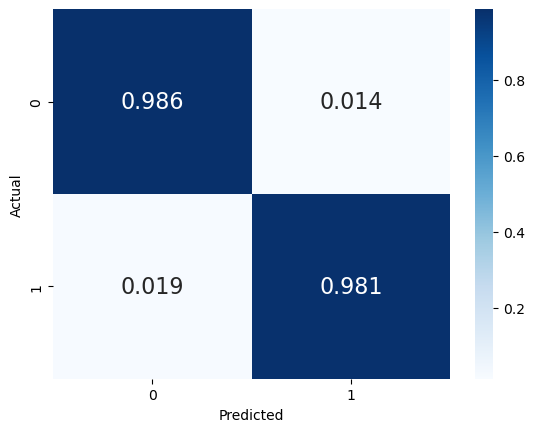

In [118]:
# Display the confusion matrix
sns.heatmap(random_forest_confusion_matrix,
           annot = True,
           fmt = '.3f',
           cmap = 'Blues',
           annot_kws = {'size': 16})
plt.xlabel("Predicted")
plt.ylabel("Actual");

Model 1 reflection needed.

# XGBoost
The second model we will use to predict diabetes in patients is XGBoost. First we must determine the best combination of hyper parameters using a grid search.

In [124]:
xgb_hp_dict = {
    'learning_rate':    [0.01, 0.05, 0.1, 0.2, 0.3], # Each new prediction's contribution to y_hat
    'n_estimators':     [100, 250, 500, 750, 1000],  # Number of trees to make
    'max_depth':        [1, 3, 5, 7],                # Maximum number of splits: 1, 8, 32, 128 leaf nodes   
    'colsample_bytree': [0.4, 0.6, 0.8, 1],          # Number of features to use per tree (40, 60, 80, & 100%)
    'lambda':           [0, 0.5, 1, 2, 5]            # Regularization parameters to try
}

In [130]:
# 5 fold cross-val
cv5 = KFold(n_splits = 5, shuffle = True, random_state = 3870)

# Defining the model:
xgb_class = XGBClassifier(random_state = 3870, early_stopping_rounds = 50)

# Defining the grid search
grid_search = GridSearchCV(
    estimator = xgb_class,
    param_grid = xgb_hp_dict,
    n_jobs = -1,
    cv = cv5    
)

fff

In [132]:
gs_results = (
    grid_search
    .fit(
        x_train, y_train,
        eval_set = [(x_test, y_test)],
        verbose = False
    )
)

In [154]:
best_hps = grid_search.best_params_
best_hps

{'colsample_bytree': 0.4,
 'lambda': 1,
 'learning_rate': 0.2,
 'max_depth': 7,
 'n_estimators': 250}

In [156]:
xgb_best_model = (
    XGBClassifier(
        **best_hps,  # Assigns the dictionary values to the parameter keys
        random_state = 3870,
        early_stopping_rounds = 20
    )
    .fit(
        x_train, y_train,
        eval_set = [(x_test, y_test)],
        verbose = False
    )
)

# Calculating the accuracy of the model
accuracy_xgb_tuned = best_model.score(x_test, y_test)
print('Train Accuracy: ',best_model.score(x_train, y_train), ' Test Accuracy: ', accuracy_xgb_tuned)

Train Accuracy:  1.0  Test Accuracy:  0.9872448979591837


In [159]:
xgb_y_pred = best_model.predict(X = x_test)

In [161]:
# Create a normalized confusion matrix of true/ false positives and negatives
XGB_confusion_matrix = confusion_matrix(
    y_true = y_test,
    y_pred = xgb_y_pred, 
    normalize = 'true'
)

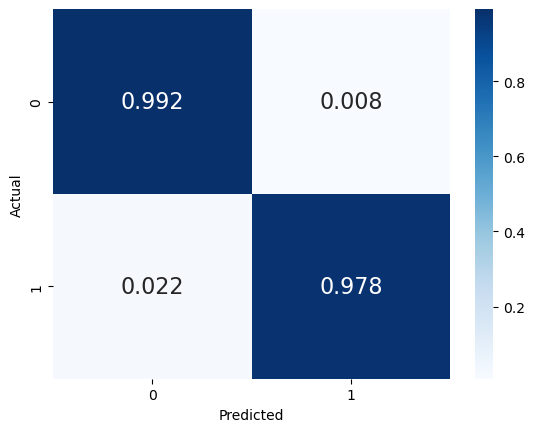

In [163]:
# Display the confusion matrix
sns.heatmap(XGB_confusion_matrix,
           annot = True,
           fmt = '.3f',
           cmap = 'Blues',
           annot_kws = {'size': 16})
plt.xlabel("Predicted")
plt.ylabel("Actual");